In [1]:
# Import libraries
import pandas as pd
import numpy as np

from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings('ignore')

# **1. Data Cleaning and Preparation**

In [2]:
data = pd.read_csv('../data/online_retail.csv')
print(f'Rows, Columns count', data.shape)
data.head()

Rows, Columns count (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


**1. Data Inspection**

In [3]:
# Data summary information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


Missing values are present in `Description, CustomerID`, `InvoiceDate, CustomerID` have incorrect datatypes

In [4]:
# Statistical summary
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


Our numerical columns are highly skewed, they also appear to have invalid values; there are negative values present

**2. Data Cleaning**

In [5]:
# Data cleaning
# Check for and drop missing values for critical columns
print(f'Missing values per column\n',data.isnull().sum())
data.dropna(subset=['InvoiceDate', 'CustomerID', 'InvoiceDate'], inplace=True)

# Change invoiceDate to DateTime format
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], errors='coerce')
# Convert customerID to str
data['CustomerID'] = data['CustomerID'].astype(int).astype(str)

# Filter invalid values in Quantity and UnitPrice columns
data = data[(data['Quantity'] > 0) & (data['UnitPrice'] > 0.01)]

# Create TransactionAmount columns
data['TransactionAmount'] = (data['UnitPrice'] * data['Quantity']).round(2)

# Inspection check
print(f'Missing values after cleaning:\n', data.isna().sum(), '\n')
print(f'Updated Rows, Columns:', data.shape)
data.head()

Missing values per column
 InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64
Missing values after cleaning:
 InvoiceNo            0
StockCode            0
Description          0
Quantity             0
InvoiceDate          0
UnitPrice            0
CustomerID           0
Country              0
TransactionAmount    0
dtype: int64 

Updated Rows, Columns: (397880, 9)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TransactionAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


**Checking Duplicate Entries**

In [6]:
print(f'Duplicate Entries: ', data.duplicated().sum()) # 5192 Duplicates
duplicates = data[data.duplicated(keep=False)]
duplicates.head() 

Duplicate Entries:  5192


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TransactionAmount
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908,United Kingdom,4.95
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908,United Kingdom,2.10
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908,United Kingdom,1.25
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908,United Kingdom,1.25
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908,United Kingdom,2.95


In [7]:
duplicate_groups = data[data.duplicated(keep=False)].groupby(list(data.columns)).size()
print(len(duplicate_groups))
duplicate_groups.head()

4809


InvoiceNo  StockCode  Description                       Quantity  InvoiceDate          UnitPrice  CustomerID  Country         TransactionAmount
536409     21866      UNION JACK FLAG LUGGAGE TAG       1         2010-12-01 11:45:00  1.25       17908       United Kingdom  1.25                 2
           22111      SCOTTIE DOG HOT WATER BOTTLE      1         2010-12-01 11:45:00  4.95       17908       United Kingdom  4.95                 2
           22866      HAND WARMER SCOTTY DOG DESIGN     1         2010-12-01 11:45:00  2.10       17908       United Kingdom  2.10                 2
           22900       SET 2 TEA TOWELS I LOVE LONDON   1         2010-12-01 11:45:00  2.95       17908       United Kingdom  2.95                 2
536412     21448      12 DAISY PEGS IN WOOD BOX         1         2010-12-01 11:49:00  1.65       17920       United Kingdom  1.65                 2
dtype: int64

In [8]:
# Drop duplicates but keep 1st occurence of a duplicated entry
data = data.drop_duplicates(keep='last')
print(f'Duplicated Entries: ', data.duplicated().sum())

Duplicated Entries:  0


In [9]:
data.describe(include=['number'])

,Quantity,UnitPrice,TransactionAmount
count,392688.000000,392688.000000,392688.00000
mean,13.119825,3.125946,22.63173
std,180.493747,22.241947,311.10080
min,1.000000,0.040000,0.06000
25%,2.000000,1.250000,4.95000
50%,6.000000,1.950000,12.45000
75%,12.000000,3.750000,19.80000
max,80995.000000,8142.750000,168469.60000


In [10]:
print(data[['Quantity', 'TransactionAmount']].skew())

Quantity             407.343614
TransactionAmount    448.519529
dtype: float64


**Handling Outliers**

In [11]:
def cap_outliers(series, lower_quantile=0.01, upper_quantile=0.99):
    lower_bound = series.quantile(lower_quantile)
    upper_bound = series.quantile(upper_quantile)
    return series.clip(lower=lower_bound, upper=upper_bound)

# # Automatically apply capping to all numeric columns
# data[data.select_dtypes(include=['float64', 'int64']).columns] = data.select_dtypes(include=['float64', 'int64']).apply(
#     lambda x: cap_outliers(x)
# )
# Columns to cap outliers
columns_to_cap = ['Quantity', 'TransactionAmount']  # Replace with your column names

# Apply the capping function to each column
for col in columns_to_cap:
    data[col] = cap_outliers(data[col])

# Check summary statistics to confirm
data.describe(include='number')

,Quantity,UnitPrice,TransactionAmount
count,392688.000000,392688.000000,392688.000000
mean,11.022504,3.125946,19.153151
std,18.158489,22.241947,29.701350
min,1.000000,0.040000,0.550000
25%,2.000000,1.250000,4.950000
50%,6.000000,1.950000,12.450000
75%,12.000000,3.750000,19.800000
max,120.000000,8142.750000,203.520000


In [12]:
data.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TransactionAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00


In [13]:
print(f'Skewness before Log-Transform after removing Outliers: \n', data[['Quantity', 'TransactionAmount']].skew(),'\n')
# print(f'Skewness after Log-Transform: \n', data[['Quantity_log', 'TransactionAmount_log']].skew())

Skewness before Log-Transform after removing Outliers: 
 Quantity             4.006558
TransactionAmount    4.164272
dtype: float64 



In [14]:
# Duplicates check
print(f'Number of Duplicates:', data.duplicated().sum(), '\n')
# Drop duplicates
data.drop_duplicates(keep='first', inplace=True)
# Inpect duplicate entries (Should return zero entries)
data[data.duplicated(keep=False)]

Number of Duplicates: 1 



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TransactionAmount


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392687 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   InvoiceNo          392687 non-null  object        
 1   StockCode          392687 non-null  object        
 2   Description        392687 non-null  object        
 3   Quantity           392687 non-null  int64         
 4   InvoiceDate        392687 non-null  datetime64[ns]
 5   UnitPrice          392687 non-null  float64       
 6   CustomerID         392687 non-null  object        
 7   Country            392687 non-null  object        
 8   TransactionAmount  392687 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 30.0+ MB


In [16]:
# Save cleaned data
data.to_pickle('../data/cleaned_data.pkl')

## **Exploratory Data Analysis**

In [17]:
df = pd.read_pickle('../data/cleaned_data.pkl')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TransactionAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


---

### **Calculate RFM Metrics**

In [18]:
# Calculate Reference data
reference_date = df['InvoiceDate'].max() + pd.DateOffset(1)
reference_date

Timestamp('2011-12-10 12:50:00')

In [19]:
# Calculate RFM Metrics
rfm = df.groupby('CustomerID').agg(
    Recency=('InvoiceDate', lambda x: (reference_date - x.max()).days),
    Frequency=('InvoiceNo', 'nunique'),
    Monetary=('TransactionAmount', 'sum')
).reset_index()

# RFM table preview
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,203.52
1,12347,2,7,4263.92
2,12348,75,4,1760.76
3,12349,19,1,1661.07
4,12350,310,1,334.40


In [20]:
# Check skewness of RFM metrics
print(rfm[["Recency", "Frequency", "Monetary"]].skew())

Recency       1.246048
Frequency    12.067031
Monetary     20.563899
dtype: float64


In [21]:
# Log-Transform RFM Metrics
rfm[["Recency_log", "Frequency_log", "Monetary_log"]] = rfm[["Recency", "Frequency", "Monetary"]].apply(lambda x: np.log1p(x)).round(2)
rfm.head()

,CustomerID,Recency,Frequency,Monetary,Recency_log,Frequency_log,Monetary_log
0,12346,326,1,203.52,5.79,0.69,5.32
1,12347,2,7,4263.92,1.10,2.08,8.36
2,12348,75,4,1760.76,4.33,1.61,7.47
3,12349,19,1,1661.07,3.00,0.69,7.42
4,12350,310,1,334.40,5.74,0.69,5.82


In [22]:
rfm[["Recency_log", "Frequency_log", "Monetary_log"]].skew()

Recency_log     -0.379257
Frequency_log    1.200459
Monetary_log     0.306526
dtype: float64

### **RFM Scoring**

In [23]:
rfm['Recency'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])
rfm['Frequency'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['Monetary'] = pd.qcut(rfm['Monetary'].rank(method='first'), 5, labels=[1,2,3,4,5])

# Combine scores into one
rfm['RFM_score'] = rfm['Recency'].astype(int) + rfm['Frequency'].astype(int) + rfm['Monetary'].astype(int)

rfm.head()

,CustomerID,Recency,Frequency,Monetary,Recency_log,Frequency_log,Monetary_log,RFM_score
0,12346,1,1,1,5.79,0.69,5.32,3
1,12347,5,5,5,1.10,2.08,8.36,15
2,12348,2,4,4,4.33,1.61,7.47,10
3,12349,4,1,4,3.00,0.69,7.42,9
4,12350,1,1,2,5.74,0.69,5.82,4


### **Value Segmentation**

In [24]:
value_labels = ['Low-value', 'Mid-value', 'High-value']
rfm['Value_segment'] = pd.qcut(rfm['RFM_score'], q=3, labels=value_labels)
# Preview
rfm.head()

,CustomerID,Recency,Frequency,Monetary,Recency_log,Frequency_log,Monetary_log,RFM_score,Value_segment
0,12346,1,1,1,5.79,0.69,5.32,3,Low-value
1,12347,5,5,5,1.10,2.08,8.36,15,High-value
2,12348,2,4,4,4.33,1.61,7.47,10,Mid-value
3,12349,4,1,4,3.00,0.69,7.42,9,Mid-value
4,12350,1,1,2,5.74,0.69,5.82,4,Low-value


### **Behavioral Segmentation**

In [25]:
def behaviour_segment(row):
    if row['RFM_score'] >= 13:
        return 'VIP'
    if row['RFM_score'] >= 10:
        return 'Loyal Customers'
    if row['RFM_score'] >= 7:
        return 'Potential Loyalists'
    if row['RFM_score'] >= 5:
        return 'At Risk'
    else:
        return 'Hibernating'
    
# Applying the segmentation strategy
rfm['Customer_segment'] = rfm.apply(behaviour_segment, axis=1)
print(rfm['Customer_segment'].value_counts())

rfm.head()

Customer_segment
Potential Loyalists    1078
Loyal Customers        1016
VIP                     931
At Risk                 766
Hibernating             547
Name: count, dtype: int64


,CustomerID,Recency,Frequency,Monetary,Recency_log,Frequency_log,Monetary_log,RFM_score,Value_segment,Customer_segment
0,12346,1,1,1,5.79,0.69,5.32,3,Low-value,Hibernating
1,12347,5,5,5,1.10,2.08,8.36,15,High-value,VIP
2,12348,2,4,4,4.33,1.61,7.47,10,Mid-value,Loyal Customers
3,12349,4,1,4,3.00,0.69,7.42,9,Mid-value,Potential Loyalists
4,12350,1,1,2,5.74,0.69,5.82,4,Low-value,Hibernating


In [26]:
# Merge the RFM metrics back to the original dataframe
df_combined = df.merge(rfm, on='CustomerID', how='left')
print(df_combined.shape)
df_combined.head(3)

(392687, 18)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TransactionAmount,Recency,Frequency,Monetary,Recency_log,Frequency_log,Monetary_log,RFM_score,Value_segment,Customer_segment
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,1,5,5,5.92,3.56,8.59,11,Mid-value,Loyal Customers
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,1,5,5,5.92,3.56,8.59,11,Mid-value,Loyal Customers
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,1,5,5,5.92,3.56,8.59,11,Mid-value,Loyal Customers


In [27]:
# Save combined DataFrame
df_combined.to_pickle('../data/combined_data.pkl')

## **Overview of Segments (RFM Analysis)**

In [76]:
# Load combined DataFrame
rfm_df = pd.read_pickle('../data/combined_data.pkl')
rfm_df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'TransactionAmount', 'Recency',
       'Frequency', 'Monetary', 'Recency_log', 'Frequency_log', 'Monetary_log',
       'RFM_score', 'Value_segment', 'Customer_segment'],
      dtype='object')

In [77]:
rfm_df[['Recency', 'Frequency', 'Monetary']] = rfm_df[['Recency', 'Frequency', 'Monetary']].astype(int)

How are the segments distributed?

Value_segment
High-value    272510
Mid-value      84209
Low-value      35968
Name: count, dtype: int64


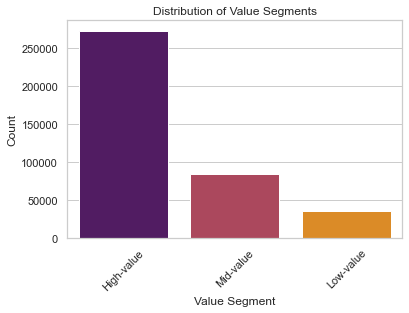

In [78]:
# Value segments
value_counts = rfm_df['Value_segment'].value_counts()
print(value_counts)

# Plot distribution
sns.countplot(data=rfm_df, x='Value_segment', order=value_counts.index, palette="inferno")
plt.title('Distribution of Value Segments')
plt.xlabel('Value Segment')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

**Investigating compositions of Value segments by customer segments**.

Group by Value_segment and calculate the percentage of Customer_segment within each value segment

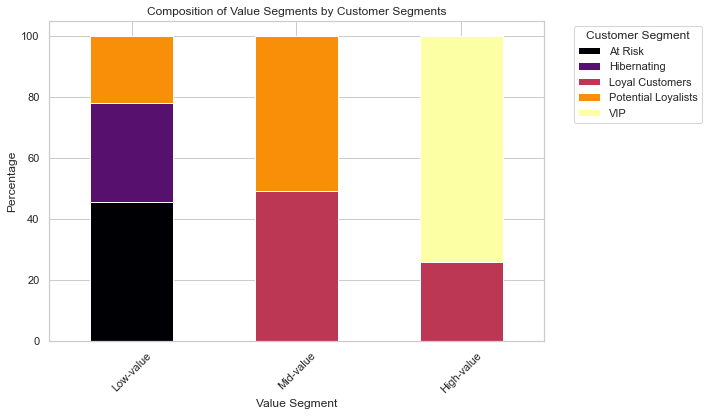

In [79]:
composition = pd.crosstab(
    rfm['Value_segment'], 
    rfm['Customer_segment'], 
    normalize='index'
).mul(100).reset_index()
# print(composition.head())

pivot_data = composition.set_index('Value_segment')
pivot_data.plot(kind='bar', stacked=True, colormap='inferno', figsize=(10, 6))
plt.title('Composition of Value Segments by Customer Segments')
plt.xlabel('Value Segment')
plt.ylabel('Percentage')
plt.legend(title='Customer Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

**Analyze Revenue contribution by value segment**

*Objective: Understand financial value of each segment*

Value_segment
Low-value      527628.31
Mid-value     1310305.44
High-value    5683075.40
Name: TransactionAmount, dtype: float64


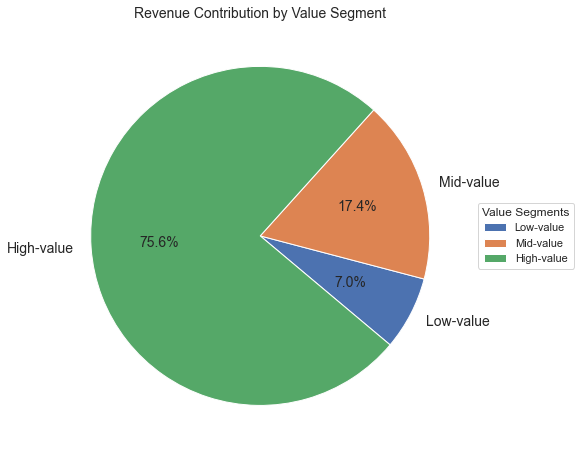

In [80]:
revenue_by_value_seg = rfm_df.groupby('Value_segment')['TransactionAmount'].sum()
print(revenue_by_value_seg)

# Plot a pie chart
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    revenue_by_value_seg, 
    labels=revenue_by_value_seg.index,  # Add segment labels
    autopct='%1.1f%%',                 # Show percentage
    startangle=320,                    # Rotate for better view
    textprops={'fontsize': 14}         # Adjust text size
)
plt.legend(
    wedges, revenue_by_value_seg.index,
    title="Value Segments",
    loc="center left",
    bbox_to_anchor=(1, 0.5)
)
plt.title('Revenue Contribution by Value Segment', fontsize=14)
plt.tight_layout()  # Adjust layout to fit everything
plt.show()

**Customer Engagement Analysis within Value Segments**

In [81]:
engagement_by_value_seg = rfm_df.groupby('Value_segment')['Frequency_log'].mean()
engagement_by_value_seg

Value_segment
Low-value     0.810562
Mid-value     1.369330
High-value    2.677773
Name: Frequency_log, dtype: float64

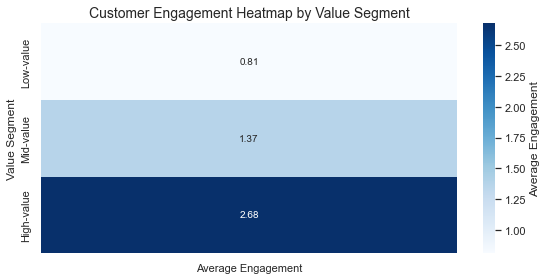

In [82]:
# Convert to DataFrame for Seaborn
engagement_df = engagement_by_value_seg.reset_index()
engagement_df.columns = ['Value Segment', 'Average Engagement']

# Plot a heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(
    engagement_df.pivot_table(index='Value Segment', values='Average Engagement'), 
    annot=True, fmt=".2f", cmap='Blues', cbar_kws={'label': 'Average Engagement'}
)
plt.title('Customer Engagement Heatmap by Value Segment', fontsize=14)
plt.tight_layout()
plt.show()

**Trend Analysis of Value Segment Behavior**

*Objective: Understand how the purchasing behavior of each value segment changes over time.*

In [83]:
rfm_df['InvoiceDate'] = pd.to_datetime(rfm_df['InvoiceDate'])
rfm_df.set_index('InvoiceDate', inplace=True)
trend_by_segment = rfm_df.groupby(['Value_segment']).resample('M')['TransactionAmount'].sum().unstack()
# trend_by_segment

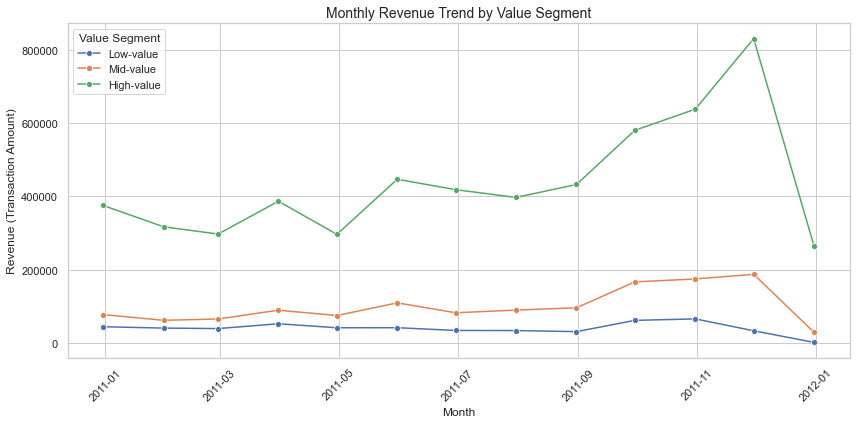

In [84]:
# Prepare data for seaborn
trend_df = trend_by_segment.stack().reset_index()
trend_df.columns = ['Value Segment', 'Month', 'Transaction Amount']

# Plot line plot
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=trend_df,
    x='Month', y='Transaction Amount', hue='Value Segment', marker='o'
)

# Add titles and labels
plt.title('Monthly Revenue Trend by Value Segment', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Revenue (Transaction Amount)', fontsize=12)

# Improve date readability
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()

**Churn Risk and Retention Analysis**

*Objective: Evaluate the churn risk for each value segment*

In [85]:
churn_by_value_segment = rfm_df.groupby('Value_segment')['Recency_log'].mean()  # Longer recency = higher churn risk
churn_by_value_segment

Value_segment
Low-value     4.854753
Mid-value     3.904243
High-value    2.243912
Name: Recency_log, dtype: float64

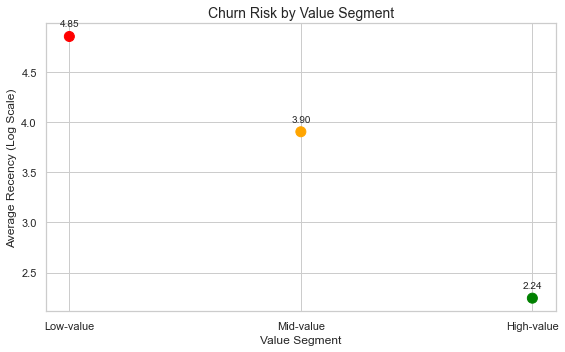

In [86]:
# Plot a dot plot
plt.figure(figsize=(8, 5))
plt.scatter(churn_by_value_segment.index, churn_by_value_segment, color=['red', 'orange', 'green'], s=100)

# Add labels and title
plt.ylabel('Average Recency (Log Scale)', fontsize=12)
plt.xlabel('Value Segment', fontsize=12)
plt.title('Churn Risk by Value Segment', fontsize=14)

# Add values near the dots
for index, value in enumerate(churn_by_value_segment):
    plt.text(index, value + 0.1, f'{value:.2f}', ha='center', fontsize=10)

# Display the chart
plt.tight_layout()
plt.show()

**Cross-Sell and Upsell Potential by Value Segment**

*Objective*: Identify potential for cross-selling and upselling within value segments.

*Approach*:
For each value segment, examine which products are frequently purchased together or which higher-value products can be suggested

In [87]:
cross_sell_potential = rfm_df.groupby(['Value_segment', 'StockCode'])['TransactionAmount'].sum().unstack()
cross_sell_potential

StockCode,10002,10080,10120,10123C,10124A,10124G,10125,10133,10135,11001,...,90214U,90214V,90214W,90214Y,90214Z,BANK CHARGES,C2,DOT,M,POST
Value_segment,,,,,,,,,,,,,,,,,,,,,
Low-value,19.55,9.36,3.28,2.60,1.26,0.00,47.30,134.31,408.35,35.49,...,0.00,0.00,0.00,13.92,0.00,30.0,661.0,0.00,1655.12,6805.89
Mid-value,53.55,11.47,15.85,0.00,1.68,3.78,134.85,349.77,217.55,576.29,...,3.48,3.48,3.48,3.48,3.48,30.0,800.0,0.00,2206.93,14762.61
High-value,626.45,93.90,24.30,0.65,3.91,3.36,747.30,655.17,1149.81,1057.06,...,0.00,2.50,0.00,1.25,0.00,105.0,5225.0,2568.61,8876.95,44578.85


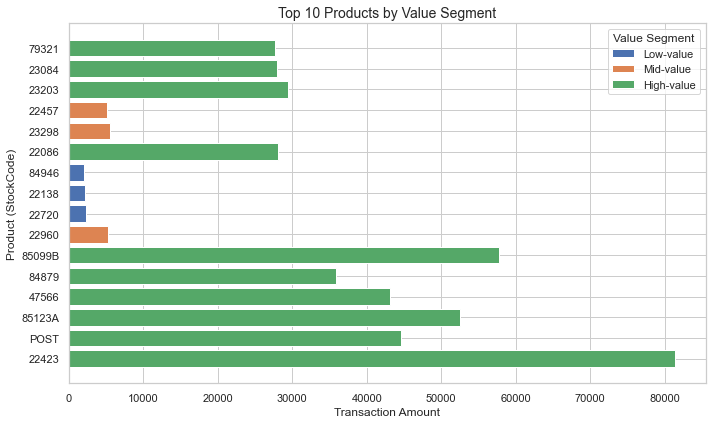

In [88]:
# Aggregate top 10 products by value segment
top_products_by_segment = cross_sell_potential.sum(axis=1).nlargest(10)

plt.figure(figsize=(10, 6))
for segment in cross_sell_potential.index:
    top_products = cross_sell_potential.loc[segment].nlargest(10)  # Top 10 products for the segment
    plt.barh(top_products.index, top_products.values, label=segment)

# Add labels and legend
plt.xlabel('Transaction Amount', fontsize=12)
plt.ylabel('Product (StockCode)', fontsize=12)
plt.title('Top 10 Products by Value Segment', fontsize=14)
plt.legend(title="Value Segment", loc='upper right')
plt.tight_layout()

# Show the plot
plt.show()

**Geographic and Demographic Insights by Value Segment**

*Objective:* 

Examine how location (Country) and demographic factors (e.g., age, gender, etc.) influence the purchasing behavior of each value segment.

*Approach:*

Look at the geographical distribution of each segment.
For example, VIP customers may be more concentrated in certain regions or countries.

In [89]:
geographic_by_segment = rfm_df.groupby(['Country', 'Value_segment'])['TransactionAmount'].sum().unstack()
geographic_by_segment.head()

Value_segment,Low-value,Mid-value,High-value
Country,,,
Australia,1208.04,4000.93,96477.16
Austria,2987.98,6141.28,715.18
Bahrain,548.40,0.00,0.00
Belgium,2937.49,11763.30,26495.55
Brazil,1143.60,0.00,0.00


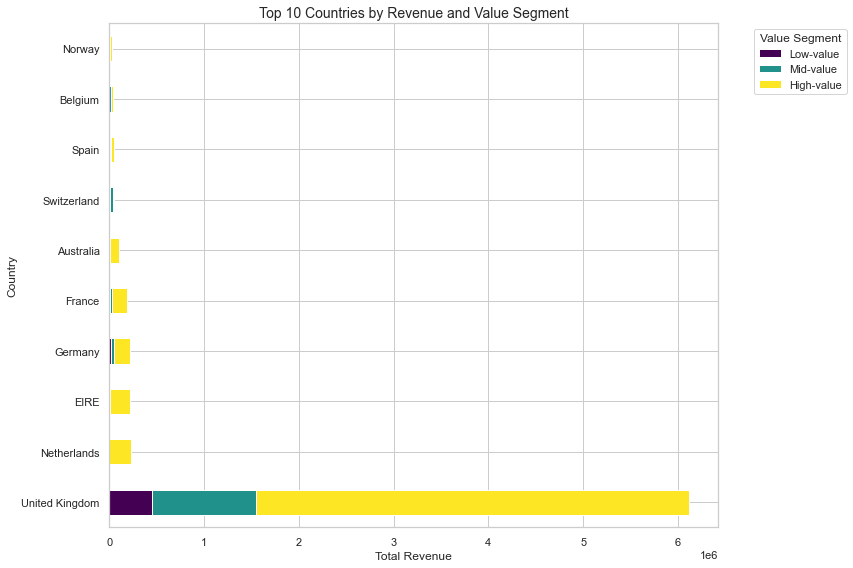

In [90]:
# Select top 10 countries
top_countries = geographic_by_segment.sum(axis=1).nlargest(10).index
stacked_data = geographic_by_segment.loc[top_countries]

# Plot a stacked bar chart
stacked_data.plot(kind='barh', stacked=True, figsize=(12, 8), colormap='viridis')

# Add labels and title
plt.xlabel('Total Revenue', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.title('Top 10 Countries by Revenue and Value Segment', fontsize=14)
plt.legend(title='Value Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the chart
plt.show()

9. **Marketing Effectiveness by Segment**

*Objective:* 

Evaluate how effective different marketing campaigns are for each segment.

*Approach*:

Compare conversion rates, response to promotions, and discount redemption rates across value segments.
Flow to Next: Allows the retailer to refine their marketing strategies for each value segment based on the campaign's performance.

### **Analyze Value Segments Over Time**

In [ ]:
# Extract year and month for analysis
rfm_df.index = pd.to_datetime(rfm_df.index) # since rfm_df has InvoiceDate as the index 
rfm_df['YearMonth'] = rfm_df.index.to_period('M')
rfm_df[['YearMonth']].head()

# Aggregate RFM metrics by time
rfm_trends = rfm_df.groupby(['YearMonth', 'Value_segment'])[['Recency', 'Frequency', 'Monetary']].mean().reset_index()

rfm_trends.head()

,YearMonth,Value_segment,Recency,Frequency,Monetary
0,2010-12,Low-value,1.089249,2.097363,1.924949
1,2010-12,Mid-value,2.364236,3.751746,3.577967
2,2010-12,High-value,4.510989,4.834203,4.794233
3,2011-01,Low-value,1.074246,1.795050,2.497680
4,2011-01,Mid-value,2.319611,3.737407,3.756840


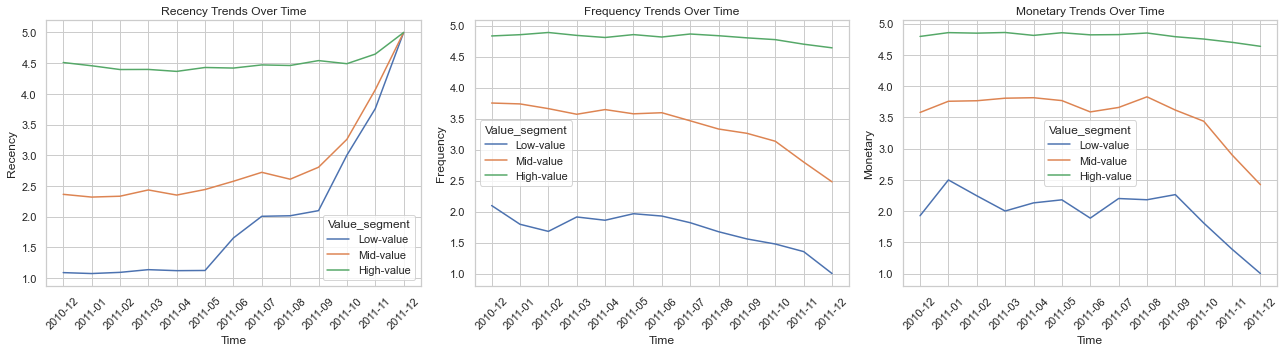

In [105]:
# Convert YearMonth to string for plotting
rfm_trends['YearMonth'] = rfm_trends['YearMonth'].astype(str)
# Plot trends for each metric
metrics =['Recency', 'Frequency', 'Monetary']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, metric in enumerate(metrics):
    sns.lineplot(data=rfm_trends, x='YearMonth', y=metric, hue='Value_segment', ax=axes[i])
    axes[i].set_title(f'{metric} Trends Over Time')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel(metric)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

**Analyze Customer Value-Segment Transitions Over Time**

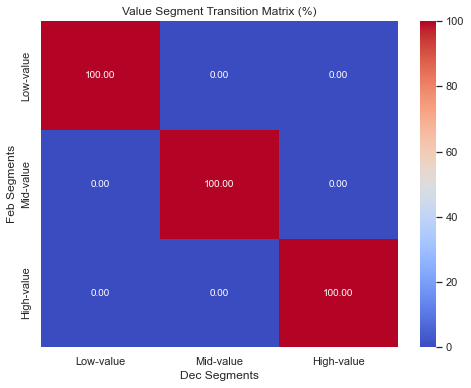

In [110]:
# Create snapshots for two time periods
snapshot_1 = rfm_df[rfm_df['YearMonth'] == '2010-12'][['CustomerID', 'Value_segment']].rename(columns={'Value_segment': 'Segment_Dec'})
snapshot_2 = rfm_df[rfm_df['YearMonth'] == '2011-06'][['CustomerID', 'Value_segment']].rename(columns={'Value_segment': 'Segment_Feb'})

# Merge snapshots to observe transitions
transitions = snapshot_1.merge(snapshot_2, on='CustomerID', how='inner')

# Generate transition matrix
transition_matrix = pd.crosstab(transitions['Segment_Dec'], transitions['Segment_Feb'], normalize='index') * 100

# Visualize the transition matrix
plt.figure(figsize=(8, 6))
sns.heatmap(transition_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Value Segment Transition Matrix (%)')
plt.xlabel('Dec Segments')
plt.ylabel('Feb Segments')
plt.show()


**Analyzing Proportion of Each Segment Over Time**

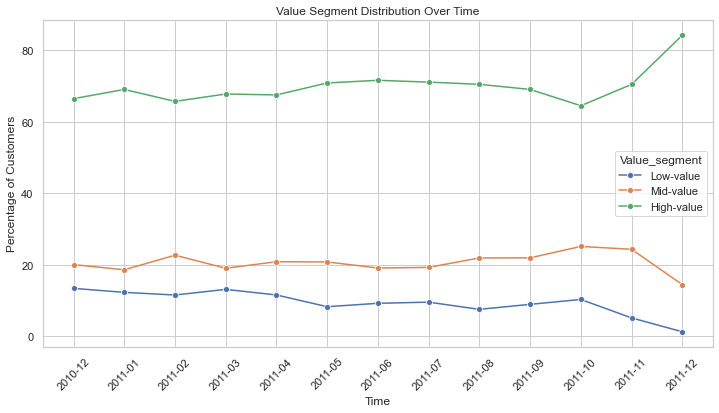

In [ ]:
# Converting period column to string for plotting
rfm_df['YearMonth'] = rfm_df['YearMonth'].astype(str)
# Create a crosstab of Value_segment by YearMonth
value_segment_crosstab = pd.crosstab(
    rfm_df['YearMonth'], 
    rfm_df['Value_segment'], 
    normalize='index'  # Normalize within each time period (row-wise)
).mul(100)  # Convert proportions to percentages

# Reset index for plotting
value_segment_crosstab = value_segment_crosstab.reset_index()

# Melt the DataFrame for Seaborn compatibility
segment_distribution = value_segment_crosstab.melt(
    id_vars='YearMonth', 
    var_name='Value_segment', 
    value_name='Percentage'
)

# Plot the segment distribution over time
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=segment_distribution, 
    x='YearMonth', y='Percentage', hue='Value_segment', marker='o'
)
plt.title('Value Segment Distribution Over Time')
plt.xlabel('Time')
plt.ylabel('Percentage of Customers')
plt.xticks(rotation=45)
plt.show()

10. **Final Recommendations for Action**

*Objective:* 

Provide actionable insights based on the combined analysis.

*Approach:*

Use the findings to create a segment-based marketing strategy, targeting each value segment with appropriate strategies like loyalty rewards, re-engagement campaigns, or personalized offers.
Flow to Next: This can result in ongoing tracking of performance, where you'll reanalyze your value segments periodically to refine strategies.